# Introduction

While searching for a dataset I found it extremely difficult to find any granular data on claims. CMS (Center for Medicare/Medicaid Services) offers a decent amount of data, however, it is not at a granular enough level to do useful time series analysis. I found this dataset via Kaggle's dataset search and although it is pet insurance, I am interested in the application in the broader healthcare space. I am going to compare some time series model as well as a deep learning method, Long Short Term Memory (LSTM). The "traditional" time series approached will be executed in R while the deep learning will be executed in Python in a separate notebook.

In [1]:
#install.packages("prophet")
#library(prophet)

In [2]:
library(lubridate)
library(dplyr)
library(ggplot2)
library(xts)
library(tidyquant)
library(zoo)
library(forecast)
library(tseries)
library(tsbox)
library(prophet)
print("Done")

Warning message:
"package 'lubridate' was built under R version 3.6.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'xts' was built under R version 3.6.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 3.6.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last


Warning message:
"package 'tidyquant' was built under R version 3.6.3"
Loading required 

[1] "Done"


In [3]:
pet_df = read.csv('E:\\Data Science\\Pet Insurance\\petdata.csv')
claims_df = read.csv('E:\\Data Science\\Pet Insurance\\claimdata.csv')

Inspecting the dataframes to see what we're working with

In [4]:
head(pet_df)
head(claims_df)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old
2,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old
3,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old
4,3,2015-01-09,2015-01-14,Dog,Mixed Breed,1 year old
5,4,2014-07-20,,Cat,Mixed Breed,8 weeks to 12 months old
6,5,2011-09-02,2014-05-07,Dog,Chihuahua,8 weeks to 12 months old


,ClaimId,PetId,ClaimDate,ClaimAmount
,<int>,<int>,<fct>,<dbl>
1,0,9273,2014-02-25,389.65
2,1,1988,2014-03-10,455.40
3,2,2452,2014-04-02,1953.79
4,3,3658,2014-04-05,243.74
5,5,9147,2014-03-18,206.42
6,6,270,2014-04-02,183.06


In [5]:
#joining the datasets so the information is all in one dataframe
insurance_df = merge(pet_df, claims_df, by = "PetId", all = TRUE)
head(insurance_df)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NA,NA,NA
2,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NA,NA,NA
3,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,26643,2018-11-16,186.76
4,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,27391,2018-06-15,162.01
5,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,7633,2018-02-14,82.80
6,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,35613,2017-12-05,567.32


In [6]:
#get the dates where a claim exists
insurance_df = insurance_df %>% filter(!is.na(ClaimDate))
head(insurance_df)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,26643,2018-11-16,186.76
2,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,27391,2018-06-15,162.01
3,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,7633,2018-02-14,82.80
4,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,35613,2017-12-05,567.32
5,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,25317,2018-07-14,27.25
6,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,37156,2018-06-04,278.88


Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.



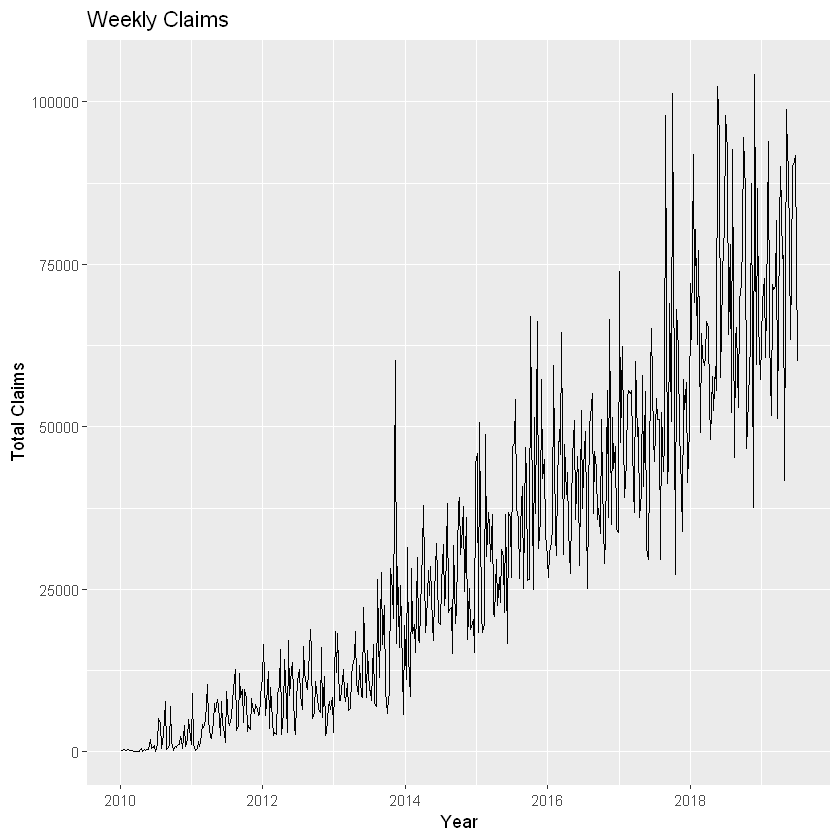

In [7]:
#Convert the claiom data to an xts object for time series analysis
ins_ts = xts(insurance_df[,c(9)], order.by = as.Date(insurance_df$ClaimDate), frequency=12)



#Downsampling data to weekly since there is not consistent daily data
weekly = apply.weekly(ins_ts[,1], sum)

ggplot(weekly, aes(x=index(weekly), y=weekly[,1])) +
       geom_line() +
        xlab("Year") +
        ylab("Total Claims") +
        ggtitle("Weekly Claims")

Looks like there is a clear trend upwards in total claim cost. It's also interesting to note the very large spike near 2014 and the increase in variability. In general, there is quite a lot of variability when looking at the data on a weekly basis.

Let's see what the data looks like when we downsample it to a monthly basis.

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.



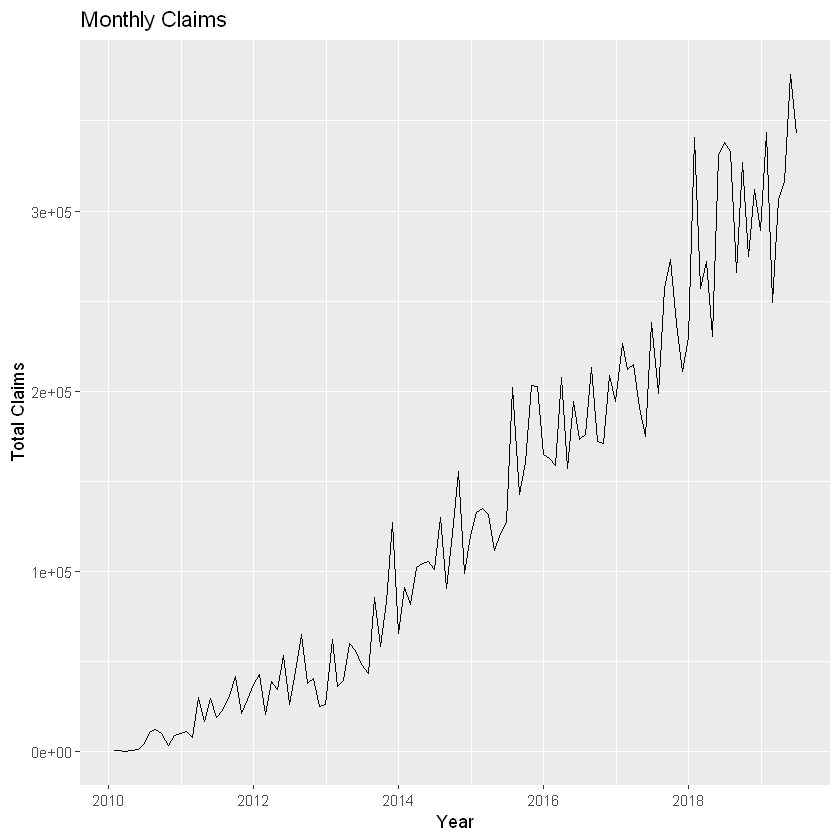

In [8]:
#Downsampling data to weekly since there is not consistent daily data
claims_monthly = apply.monthly(ins_ts[,1], sum)
attr(claims_monthly, "frequency") = 12

ggplot(claims_monthly, aes(x=index(claims_monthly), y=claims_monthly[,1])) +
       geom_line() +
        xlab("Year") +
        ylab("Total Claims") +
        ggtitle("Monthly Claims")

Some seasonality is a little more apparent in the dataset when looking at it on a monthly basis, as well as the increasing trend. I think it may also be useful to look at the data on a normalized claim basis, that is that the total claims divided by the number of claims. This will help answer the question of whether indiviudal claim costs are increasing or it is mostly driven by aggregage claims.

In [9]:
head(insurance_df)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,26643,2018-11-16,186.76
2,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,27391,2018-06-15,162.01
3,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,7633,2018-02-14,82.80
4,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,35613,2017-12-05,567.32
5,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,25317,2018-07-14,27.25
6,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,37156,2018-06-04,278.88


In [10]:
#Get the claim counts
claim_counts = insurance_df %>%
                group_by(Date = as.Date(ClaimDate)) %>%
                summarise( Total_Claims = n())

#convert to xts
claim_counts = xts(claim_counts[,"Total_Claims"], order.by = as.Date(claim_counts$Date))

#Aggregate to monthly basis
claimct_monthly = apply.monthly(claim_counts[,"Total_Claims"], sum)

#Divide claims by claim count
norm_claims = claims_monthly/claimct_monthly

`summarise()` ungrouping output (override with `.groups` argument)



Warning is OK as there is only one grouping variable

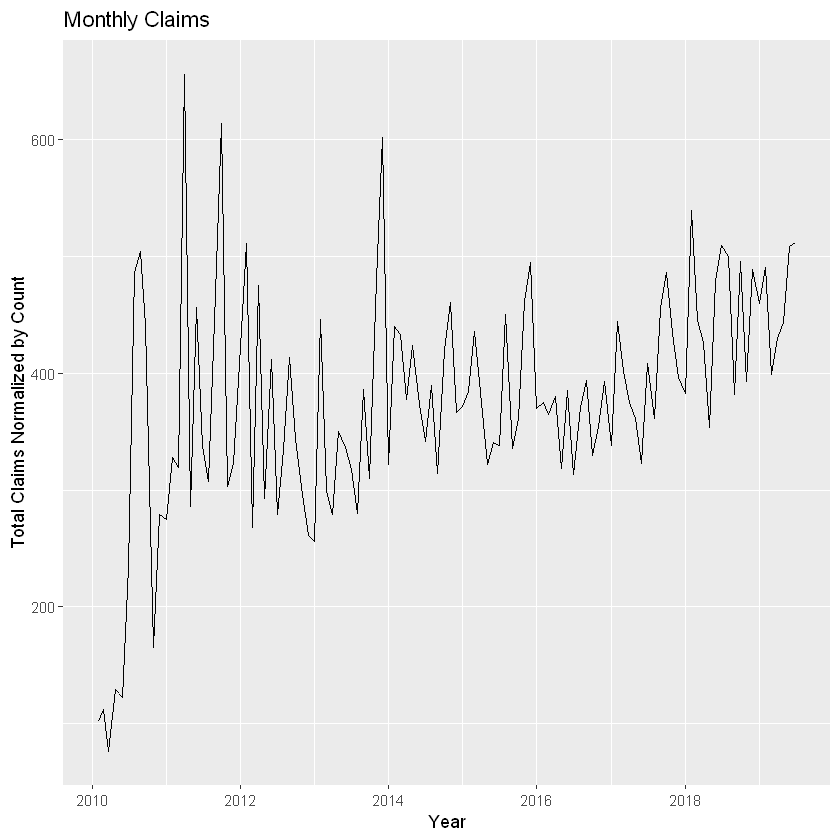

In [11]:
ggplot(data = norm_claims, aes(x=index(norm_claims), y=Total_Claims)) +
        geom_line()  +
        xlab("Year") +
        ylab("Total Claims Normalized by Count") +
        ggtitle("Monthly Claims")

Looks like overall the cost is trending slightly upwards on a per claim basis. Next let's look at the autocorrelation plot for the total monthly claims.

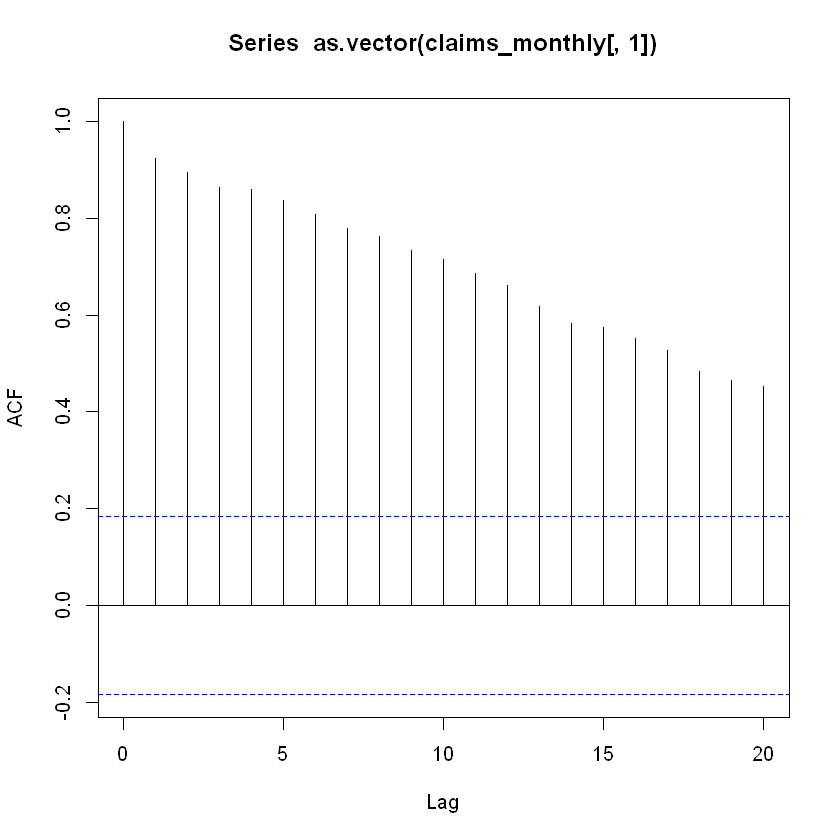

In [12]:
acf(as.vector(claims_monthly[,1]))

Looks like the data would be best differenced by 1 (as indicated by the steadily decreasing autocorrelation pattern). Let's take care of that then look at the data and autocorrelations again.

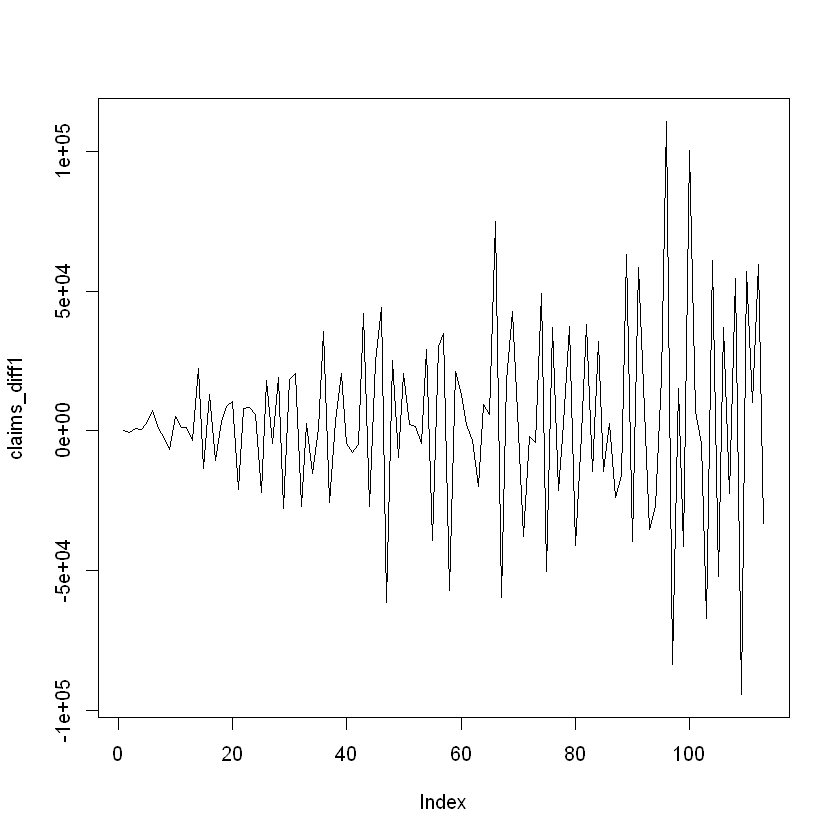

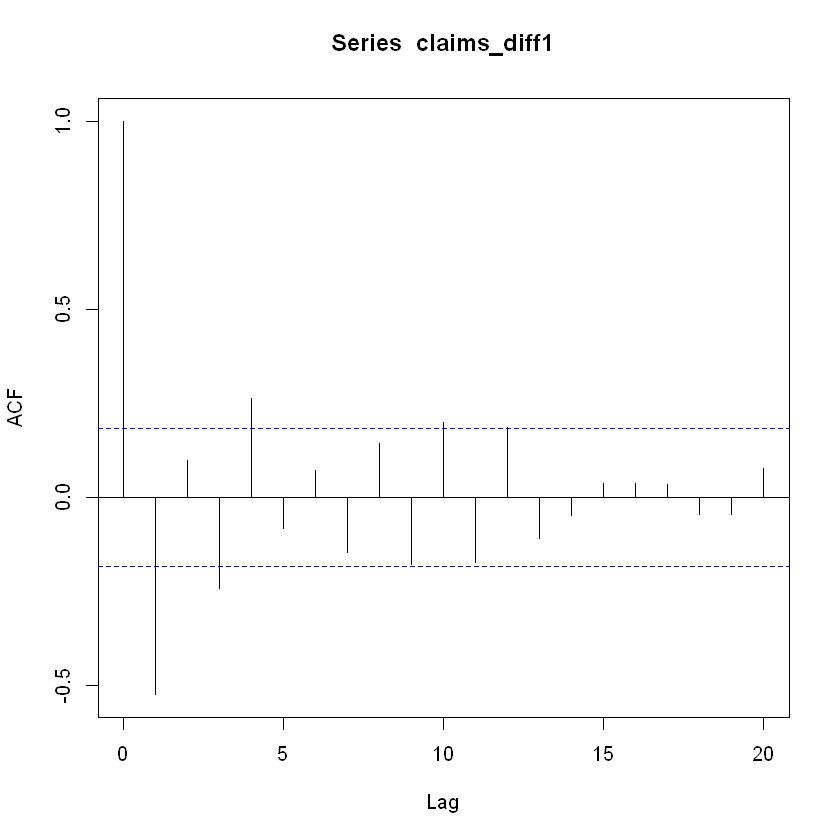

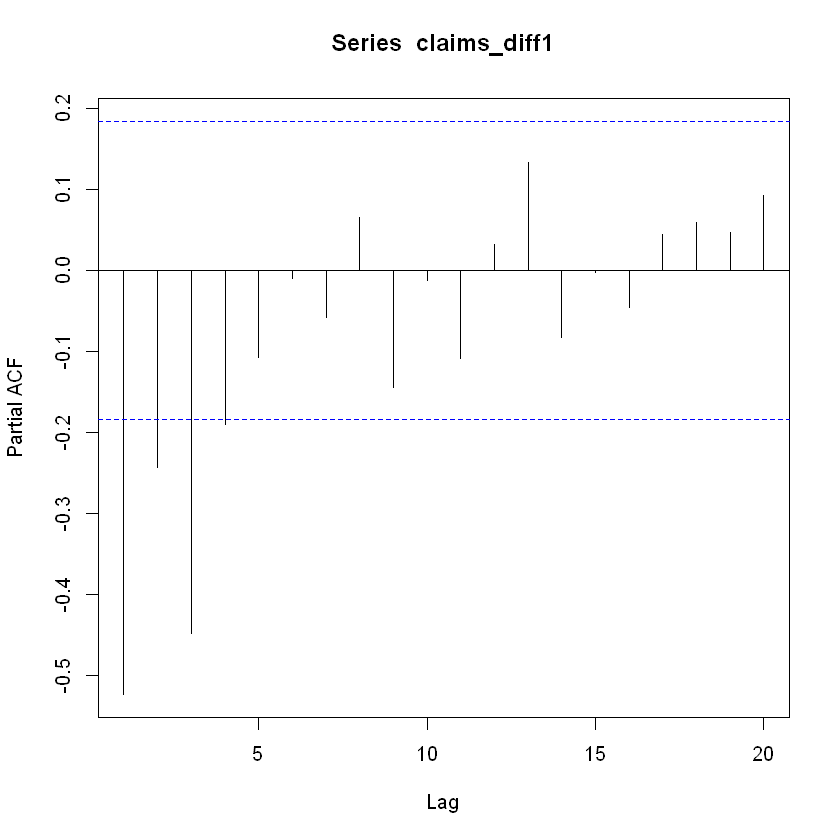

In [13]:
#difference the data by 1 lag
claims_diff1 = diff(claims_monthly, lag=1)
claims_diff1 = as.vector(claims_diff1[complete.cases(claims_diff1)][,1])

#plot the differenced data
plot(claims_diff1, type='l')

#plot the differenced acf data
acf(claims_diff1)

#plot the partial autocorrelation function
pacf(claims_diff1)

Looking at the differenced data, it looks like we might not have stationary data since the variance increases over time. Also by choosing a lag of 1 we are actually over differenced as noted by the large negative at lag 1. Since the autocorrelation is negative we want to introduce an MA to smooth things out. It is also important to note that when an AR/MA term is added another order of differencing could work slightly better.

There is also a great amount of subjectivity and it is difficult to know what combination of AR/MA parameters would best fit the data. This is where auto.arima comes in handy and will help automate some of this process. I need to separate the data into train and test data first as well as perform a Dickey-Fuller test on the entire dataset.

In [37]:
# The BoxCox.lambda() function will choose a value of lambda
lam = BoxCox.lambda(as.vector(claims_monthly), method = "loglik")
transformed_data = BoxCox(as.vector(claims_monthly), lam)
claims_monthly[,1] = transformed_data

ERROR: Error in melt(claims_monthly, measure.vars = c("value", "y")): could not find function "melt"


In [14]:
# Random sample indexes
train_index= 0.8 * nrow(claims_monthly)


# Build train and test
train = claims_monthly[1:train_index,]

test = claims_monthly[train_index:length(claims_monthly), ]
#test = ts_xts(test)

In [15]:
#Dickey-Fuller test
adf.test(claims_monthly, k=1)

Warning message in adf.test(claims_monthly, k = 1):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  claims_monthly
Dickey-Fuller = -4.512, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


The result is we reject the null hypothesis that the data is <b>not</b> stationary. The evidence supports the alternative hypothesis that the data is stationary when using a lag order of 1.

In [16]:
auto_arima = auto.arima(x=train, trace=TRUE, max.p = 12, max.q = 12, D = 1, ic="aicc", approximation=FALSE)
arima_forecast = forecast(auto_arima, h=12)
auto_arima


 ARIMA(2,1,2)(1,1,1)[12]                    : Inf
 ARIMA(0,1,0)(0,1,0)[12]                    : 1859.456
 ARIMA(1,1,0)(1,1,0)[12]                    : 1826.756
 ARIMA(0,1,1)(0,1,1)[12]                    : Inf
 ARIMA(1,1,0)(0,1,0)[12]                    : 1840.212
 ARIMA(1,1,0)(2,1,0)[12]                    : 1822.151
 ARIMA(1,1,0)(2,1,1)[12]                    : Inf
 ARIMA(1,1,0)(1,1,1)[12]                    : Inf
 ARIMA(0,1,0)(2,1,0)[12]                    : 1840.105
 ARIMA(2,1,0)(2,1,0)[12]                    : 1806.25
 ARIMA(2,1,0)(1,1,0)[12]                    : 1807.757
 ARIMA(2,1,0)(2,1,1)[12]                    : Inf
 ARIMA(2,1,0)(1,1,1)[12]                    : Inf
 ARIMA(3,1,0)(2,1,0)[12]                    : 1805.805
 ARIMA(3,1,0)(1,1,0)[12]                    : 1807.732
 ARIMA(3,1,0)(2,1,1)[12]                    : Inf
 ARIMA(3,1,0)(1,1,1)[12]                    : Inf
 ARIMA(4,1,0)(2,1,0)[12]                    : 1800.756
 ARIMA(4,1,0)(1,1,0)[12]                    : 1801

Series:  
ARIMA(4,1,0)(2,1,0)[12] 

Coefficients:
          ar1      ar2      ar3      ar4     sar1     sar2
      -0.9212  -0.8334  -0.4494  -0.3101  -0.7155  -0.2606
s.e.   0.1204   0.1515   0.1432   0.1094   0.1241   0.1348

sigma^2 estimated as 498921861:  log likelihood=-892.58
AIC=1799.16   AICc=1800.76   BIC=1815.65

$$#$$
Let's take a look at the fit of the model compared to our data

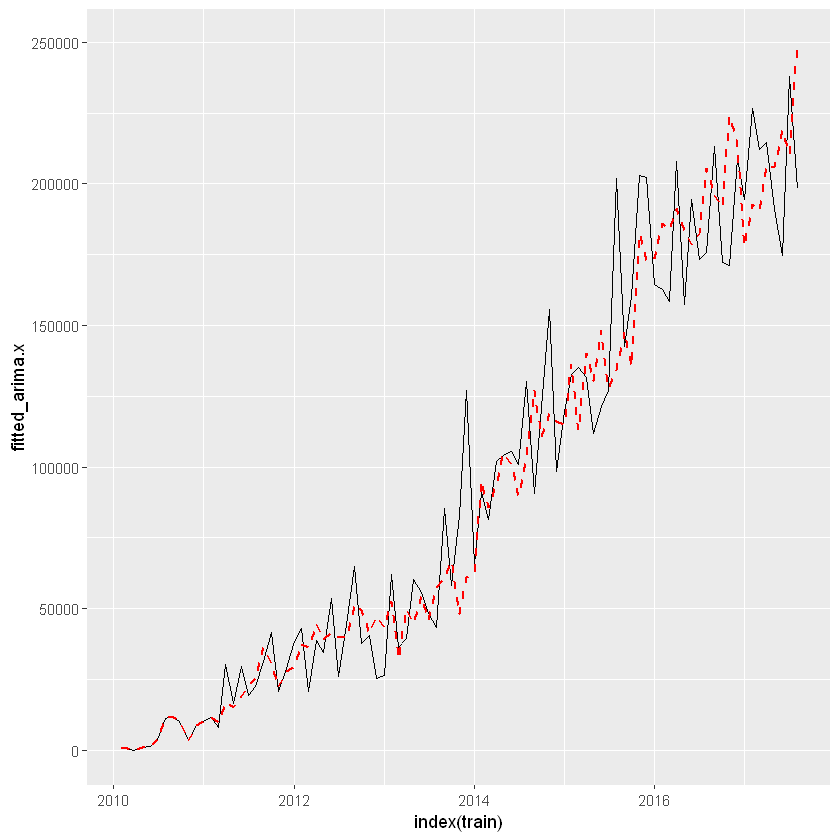

In [17]:
#fit the model
fitted_arima = Arima(train, order = c(4, 1, 0), seasonal = c(2, 1, 0))

#data originall fed into model
orig_data = data.frame(fitted_arima$x)

#fitted data
fitted_data = data.frame(fitted(fitted_arima))                       
              
#get forecast values
test_forecast = data.frame(predict(fitted_arima, 23))
rownames(test_forecast) = index(test)

#plotting data vs fit                        
ggplot() +
geom_line(data = orig_data, aes(x = index(train), y = fitted_arima.x), col='black') +
geom_line(data = fitted_data, aes(x = index(train), y = fitted.fitted_arima.), col='red', linetype='dashed', size=0.8)

We can see that the model still has issues picking up on the spikes, especially around 2014. Adding something like a sine/fourier series could improve the model, but I am interested in trying different algorithms to see if they can better pick up on the data out of the box.

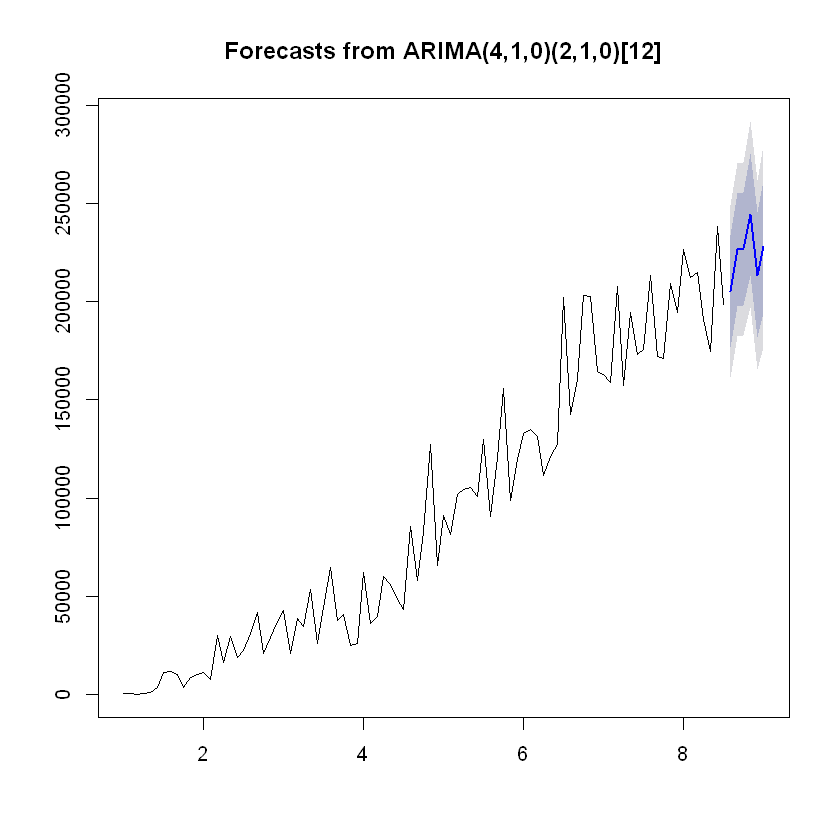

In [18]:
fitted_arima %>%
  forecast(h=6) %>%

plot() #+ autolayer(test)

In [19]:
my_forecast = forecast(fitted_arima, h=23, level = c(95))

In [20]:
forecast_reformatted = cbind(y = my_forecast$mean, y.lo = my_forecast$lower, y.hi = my_forecast$upper )
forecast_xts = xts(forecast_reformatted, index(test))

myxts_reformatted = cbind(y = train, y.lo = NA, y.hi = NA)
#myxts_final = xts(myxts_reformatted)

train_test = rbind(myxts_reformatted, forecast_xts)

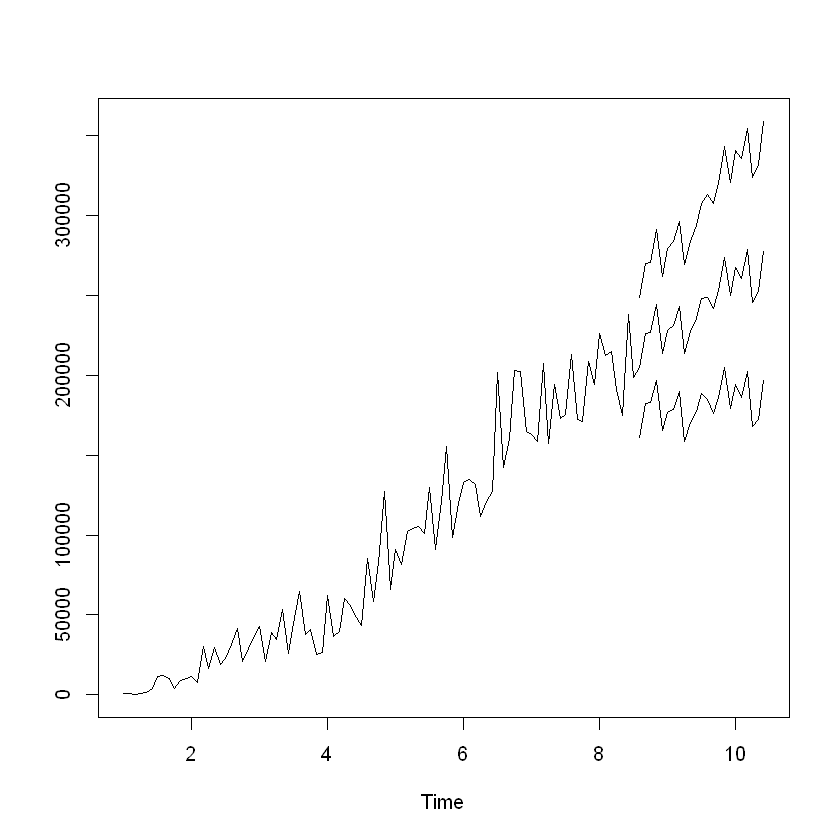

In [21]:
train_test %>% ts.plot()

Moving on to some slightly more complex algorithms.

### Prophet

Next I'd like to test what we can achieve using a more modern time series model, such as the Prophet algorithm developed by Facebook. While it is recommended to use daily data, we don't have daily observations. We'll stick to using monthly data as it's still possible to use Prophet.

In [22]:
head(insurance_df, 1)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>
1,2,2014-12-20,,Dog,French Bulldog,8 weeks to 12 months old,26643,2018-11-16,186.76


In [23]:
#Change column to date type
insurance_df["EnrollDate"] = as.Date(insurance_df[["EnrollDate"]])

#change empty cells to end of month date for cancel date (active policies)
insurance_df$CancelDate[insurance_df["CancelDate"] == ""] = "2019-06-30"
insurance_df$CancelDate = as.Date(insurance_df$CancelDate)

#number the days the policy has been inforce
days_insured = (insurance_df["CancelDate"] - insurance_df["EnrollDate"])
        

Taking a look at the distribution of how long a policy stays inforce in terms of days and (approximately) in terms of months out of curiosity.

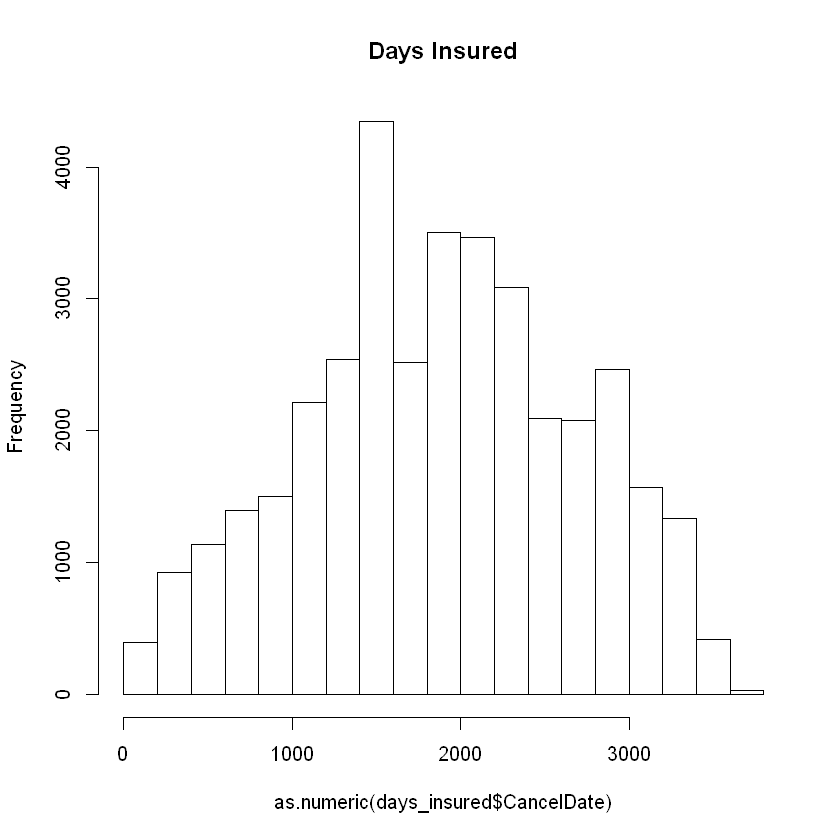

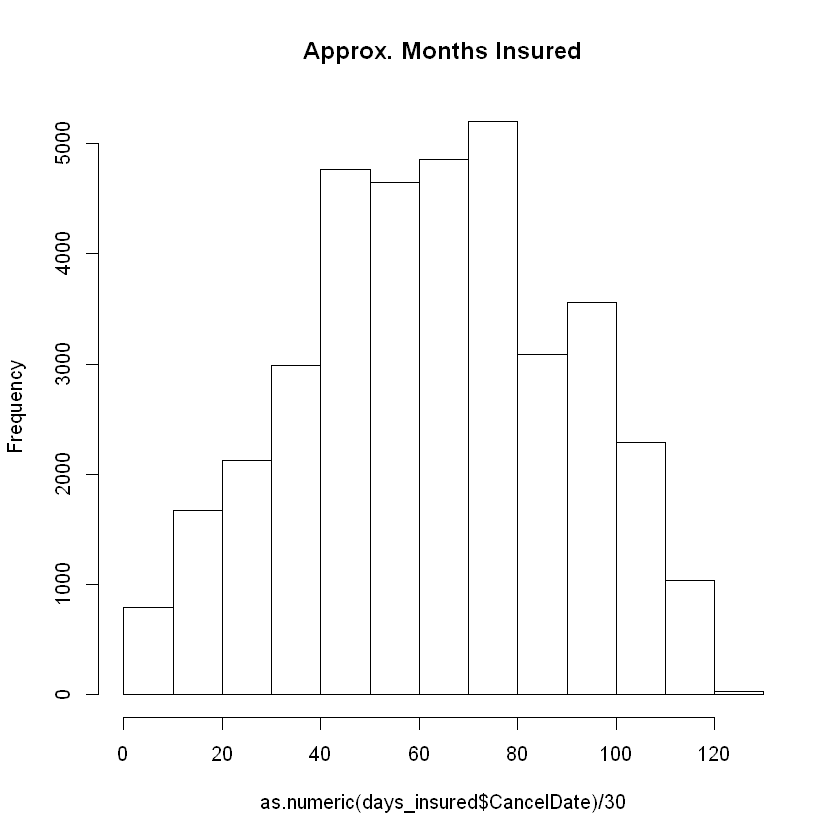

In [24]:
hist(as.numeric(days_insured$CancelDate), main = "Days Insured")
hist(as.numeric(days_insured$CancelDate)/30, main = "Approx. Months Insured")

Looks like most pets have been insured between a little over 3 years to a little over 6 years and the distribution is approximately normal.

In [25]:
prophet_df = insurance_df[,c(4,5,6,8,9)]
head(merge(prophet_df, days_insured, by=1))

Species,Breed,AgeAtEnroll,ClaimDate,ClaimAmount
<fct>,<fct>,<fct>,<fct>,<dbl>


In [26]:
days_insured

CancelDate
<drtn>
1653 days
1653 days
1653 days
1653 days
1653 days
1653 days
1653 days
1653 days
1653 days
